In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
!pip install datasets

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import torch
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from transformers import AdamW, AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, get_scheduler, TrainingArguments, Trainer
from datasets import Dataset

In [119]:
# Here the loaded data is processed in hw3_trainer_pre_process.ipynb
data_train = pd.read_csv('data_train_reg.csv')
data_dev = pd.read_csv('data_dev_reg.csv')
data_test = pd.read_csv('data_test.csv')

trainset = Dataset.from_pandas(data_train)
devset = Dataset.from_pandas(data_dev)

In [6]:
data_train.head()

,question_text,reply_text,rate
0,"Is there someone you turned down in the past, ...",Idk if this counts but my when I was younger m...,4.75
1,"What is, in your opinion, the saddest villain ...",My man Dr Heinz Doofenschmirts was born withou...,3.75
2,ELI5: How do we still not know how eels reprod...,"For a long time, it wasn't known how eels mate...",3.50
3,ELI5: Why can’t freshwater fish live in saltwa...,A living cell is designed to work at specific ...,4.00
4,What's something nice you like to do just to b...,Give compliments. It’s extremely easy to do an...,4.40


## Problem11 Using trainer to do regression

In [ ]:
# checkpoint = 'bert-base-uncased'
# checkpoint = 'distilbert-base-uncased'
checkpoint = "microsoft/MiniLM-L12-H384-uncased"  # the model has no maximum length parameter to pad with

tokenizer = AutoTokenizer.from_pretrained(checkpoint, model_max_length=512)

# def tokenize_function(example):
#     return tokenizer(example["question_text"], example["reply_text"], truncation=True)

def tokenize_function(example):
    return tokenizer(example["question_text"], example["reply_text"], truncation=True)

tokenized_trainset = trainset.map(tokenize_function, batched=True)
tokenized_devset = devset.map(tokenize_function, batched=True)

# remove the unexpected text, only keep the tokenized data and the labels
tokenized_trainset = tokenized_trainset.remove_columns(["question_text", "reply_text"])
tokenized_trainset = tokenized_trainset.rename_column("rate", "labels")
tokenized_devset = tokenized_devset.remove_columns(["question_text", "reply_text"])
tokenized_devset = tokenized_devset.rename_column("rate", "labels")

In [ ]:
# when using regression, the num_label should be set to 1
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)

In [117]:
args = TrainingArguments(
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-6,
    num_train_epochs=6,
    report_to="none",
    weight_decay=0.01,
    output_dir='train_with_reg',
    logging_steps = 400
)


trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_trainset,
    eval_dataset=tokenized_devset,
    tokenizer=tokenizer,
)

PyTorch: setting up devices


In [118]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3779
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2838


Epoch,Training Loss,Validation Loss
1,0.037900,0.521022
2,0.035700,0.511633
3,0.033900,0.499932
4,0.030900,0.508891
5,0.033900,0.515199
6,0.029600,0.513663


***** Running Evaluation *****
  Num examples = 811
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-473
Configuration saved in train_with_reg/checkpoint-473/config.json
Model weights saved in train_with_reg/checkpoint-473/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-473/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-473/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 811
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-946
Configuration saved in train_with_reg/checkpoint-946/config.json
Model weights saved in train_with_reg/checkpoint-946/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-946/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-946/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 811
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1419
Configuration sav

TrainOutput(global_step=2838, training_loss=0.033256495939836775, metrics={'train_runtime': 460.6785, 'train_samples_per_second': 49.219, 'train_steps_per_second': 6.16, 'total_flos': 919839936934338.0, 'train_loss': 0.033256495939836775, 'epoch': 6.0})

In [120]:
predictions = trainer.predict(tokenized_devset)

***** Running Prediction *****
  Num examples = 811
  Batch size = 8


In [121]:
# calculate the performance

print("Mean square error: ", mean_squared_error(predictions.label_ids, predictions.predictions, squared=False))
print("Correlation: ", pearsonr(predictions.label_ids, predictions.predictions.flatten())[0])

Mean square error:  0.71670306
Correlation:  0.6067053696840444


In [ ]:
predictions.predictions.flatten()

## Problem 12 Prediction

In [140]:
# use the public test set to make predictions
test_out = data_test[['id']]
test_input = data_test[["question_text", "reply_text"]]
# test_input['labels'] = 1

test_dt = Dataset.from_pandas(test_input)
test_tkn = test_dt.map(tokenize_function, batched=True).remove_columns(["question_text", "reply_text"])

pred_test = trainer.predict(test_tkn)


  0%|          | 0/1 [00:00<?, ?ba/s]

***** Running Prediction *****
  Num examples = 810
  Batch size = 8


In [141]:
label = pred_test.predictions.flatten()
test_out['predicted'] = label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [144]:
test_out.to_csv('upload.csv', index=False, encoding='utf8')

## Problem 13 evaluation

In [50]:
# get the group_lst
group_lst = pd.read_csv('si630w22-hw3-train.csv')['group'].unique().tolist()
group_lst.sort()

In [ ]:
train_dict = {}
dev_a_dict = {}
dev_b_dict = {}
dev_c_dict = {}


for g in group_lst:
    train_dt = Dataset.from_pandas(pd.read_csv('P13_evaluation/' + g + '_train' + '.csv'))
    dev_a_dt = Dataset.from_pandas(pd.read_csv('P13_evaluation/' + g + '_dev_a' + '.csv'))
    dev_b_dt = Dataset.from_pandas(pd.read_csv('P13_evaluation/' + g + '_dev_b' + '.csv'))
    dev_c_dt = Dataset.from_pandas(pd.read_csv('P13_evaluation/' + g + '_dev_c' + '.csv'))

    trainset_tkn = train_dt.map(tokenize_function, batched=True).remove_columns(["question_text", "reply_text"]).rename_column("rate", "labels")
    dev_aset_tkn = dev_a_dt.map(tokenize_function, batched=True).remove_columns(["question_text", "reply_text"]).rename_column("rate", "labels")
    dev_bset_tkn = dev_b_dt.map(tokenize_function, batched=True).remove_columns(["question_text", "reply_text"]).rename_column("rate", "labels")
    dev_cset_tkn = dev_c_dt.map(tokenize_function, batched=True).remove_columns(["question_text", "reply_text"]).rename_column("rate", "labels")

    train_dict[g] = trainset_tkn
    dev_a_dict[g] = dev_aset_tkn
    dev_b_dict[g] = dev_bset_tkn
    dev_c_dict[g] = dev_cset_tkn




In [80]:
a_lst = []
b_lst = []
c_lst = []

for g in tqdm(group_lst):

    trainer2 = Trainer(
    model,
    args,
    train_dataset=train_dict[g],
    eval_dataset=dev_a_dict[g],
    tokenizer=tokenizer)

    trainer2.train()

    # (a) Evaluation
    pred_a = trainer2.predict(dev_a_dict[g])
    a_lst.append(pearsonr(pred_a.label_ids, pred_a.predictions.flatten())[0])

    # (b) Evaluation
    pred_b = trainer2.predict(dev_b_dict[g])
    b_lst.append(pearsonr(pred_b.label_ids, pred_b.predictions.flatten())[0])

    # (c) Evaluation
    pred_c = trainer2.predict(dev_c_dict[g])
    c_lst.append(pearsonr(pred_c.label_ids, pred_c.predictions.flatten())[0])




  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3768
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.310300,0.545107
2,0.315400,0.620307
3,0.299300,0.535589
4,0.294000,0.549302
5,0.301900,0.548310
6,0.281100,0.551716


***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 77
  Batch size = 8
***** Running Prediction *****
  Num examples = 75
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3767
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.284200,0.492242
2,0.282000,0.619784
3,0.261800,0.575809
4,0.253800,0.529945
5,0.258400,0.564575
6,0.247400,0.558884


***** Running Evaluation *****
  Num examples = 806
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 806
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 806
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 64
  Batch size = 8
***** Running Prediction *****
  Num examples = 59
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.275400,0.544468
2,0.268300,0.535374
3,0.248500,0.597350
4,0.253400,0.608561
5,0.234100,0.595604
6,0.218300,0.578231


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 62
  Batch size = 8
***** Running Prediction *****
  Num examples = 58
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3769
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2832


Epoch,Training Loss,Validation Loss
1,0.254000,0.554471
2,0.243800,0.644957
3,0.222200,0.573542
4,0.219000,0.605869
5,0.206300,0.650375
6,0.195000,0.587233


***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-472
Configuration saved in train_with_reg/checkpoint-472/config.json
Model weights saved in train_with_reg/checkpoint-472/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-472/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-472/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-944
Configuration saved in train_with_reg/checkpoint-944/config.json
Model weights saved in train_with_reg/checkpoint-944/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-944/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-944/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1416
Configuration sav

***** Running Prediction *****
  Num examples = 58
  Batch size = 8
***** Running Prediction *****
  Num examples = 56
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.223100,0.547777
2,0.206100,0.645501
3,0.184800,0.651628
4,0.189500,0.614323
5,0.174900,0.590786
6,0.172500,0.601666


***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 75
  Batch size = 8
***** Running Prediction *****
  Num examples = 72
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.208100,0.585860
2,0.200000,0.554162
3,0.182000,0.587086
4,0.173000,0.574388
5,0.157600,0.582937
6,0.154200,0.600029


***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 66
  Batch size = 8
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3768
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.171800,0.622236
2,0.170200,0.664769
3,0.160700,0.559964
4,0.145400,0.572737
5,0.144900,0.568354
6,0.137600,0.579893


***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 67
  Batch size = 8
***** Running Prediction *****
  Num examples = 64
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3768
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.155000,0.569080
2,0.148400,0.545330
3,0.143700,0.586913
4,0.127300,0.571189
5,0.128200,0.577566
6,0.114700,0.584031


***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 61
  Batch size = 8
***** Running Prediction *****
  Num examples = 59
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3764
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.139500,0.536382
2,0.138200,0.586570
3,0.123900,0.556511
4,0.119800,0.569847
5,0.113300,0.593525
6,0.105100,0.578944


***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 53
  Batch size = 8
***** Running Prediction *****
  Num examples = 52
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.131100,0.568654
2,0.126500,0.563903
3,0.119600,0.582651
4,0.110200,0.564935
5,0.102700,0.559936
6,0.096300,0.578250


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 71
  Batch size = 8
***** Running Prediction *****
  Num examples = 67
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3768
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.114000,0.552947
2,0.105400,0.586379
3,0.108900,0.551119
4,0.099500,0.591356
5,0.101000,0.579090
6,0.091100,0.578367


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 71
  Batch size = 8
***** Running Prediction *****
  Num examples = 67
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3767
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.106000,0.583118
2,0.093000,0.583723
3,0.092300,0.568207
4,0.087000,0.561579
5,0.084200,0.566416
6,0.075500,0.567159


***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 63
  Batch size = 8
***** Running Prediction *****
  Num examples = 62
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3765
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.091500,0.608480
2,0.087400,0.559127
3,0.084200,0.573620
4,0.075700,0.579810
5,0.075700,0.575043
6,0.067600,0.582493


***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 810
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 76
  Batch size = 8
***** Running Prediction *****
  Num examples = 75
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.086900,0.588406
2,0.083700,0.587392
3,0.076900,0.599917
4,0.069800,0.590533
5,0.068000,0.577069
6,0.063200,0.583316


***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 63
  Batch size = 8
***** Running Prediction *****
  Num examples = 60
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.078000,0.584835
2,0.078400,0.561321
3,0.067600,0.593662
4,0.068700,0.564559
5,0.063700,0.556320
6,0.058300,0.562295


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 58
  Batch size = 8
***** Running Prediction *****
  Num examples = 54
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3765
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.084200,0.572361
2,0.081200,0.551701
3,0.076500,0.564494
4,0.072600,0.557411
5,0.065000,0.544428
6,0.063800,0.553287


***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 63
  Batch size = 8
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3768
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.087900,0.528837
2,0.084600,0.531312
3,0.076600,0.538866
4,0.070100,0.539375
5,0.067400,0.534813
6,0.062500,0.531697


***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 809
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 69
  Batch size = 8
***** Running Prediction *****
  Num examples = 67
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3763
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.068100,0.571840
2,0.062200,0.577075
3,0.062400,0.583057
4,0.058700,0.570075
5,0.054000,0.567426
6,0.049300,0.567300


***** Running Evaluation *****
  Num examples = 811
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 811
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 811
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 65
  Batch size = 8
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3770
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2832


Epoch,Training Loss,Validation Loss
1,0.080100,0.529110
2,0.076400,0.561423
3,0.073800,0.559031
4,0.062600,0.543688
5,0.058700,0.551814
6,0.056100,0.544993


***** Running Evaluation *****
  Num examples = 806
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-472
Configuration saved in train_with_reg/checkpoint-472/config.json
Model weights saved in train_with_reg/checkpoint-472/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-472/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-472/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 806
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-944
Configuration saved in train_with_reg/checkpoint-944/config.json
Model weights saved in train_with_reg/checkpoint-944/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-944/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-944/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 806
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1416
Configuration sav

***** Running Prediction *****
  Num examples = 64
  Batch size = 8
***** Running Prediction *****
  Num examples = 59
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.063700,0.556437
2,0.058400,0.557954
3,0.057000,0.567482
4,0.054200,0.542176
5,0.049200,0.543226
6,0.047000,0.550999


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 59
  Batch size = 8
***** Running Prediction *****
  Num examples = 55
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3767
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.068600,0.591635
2,0.063200,0.583428
3,0.059400,0.571776
4,0.058600,0.566547
5,0.054400,0.563942
6,0.049700,0.563817


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 52
  Batch size = 8
***** Running Prediction *****
  Num examples = 48
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3765
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.066600,0.553027
2,0.057100,0.529381
3,0.057300,0.538101
4,0.053800,0.538132
5,0.052100,0.540431
6,0.046300,0.539368


***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 64
  Batch size = 8
***** Running Prediction *****
  Num examples = 61
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3770
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2832


Epoch,Training Loss,Validation Loss
1,0.062300,0.571692
2,0.061900,0.551847
3,0.055800,0.543761
4,0.053500,0.539321
5,0.052300,0.543366
6,0.046400,0.544558


***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-472
Configuration saved in train_with_reg/checkpoint-472/config.json
Model weights saved in train_with_reg/checkpoint-472/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-472/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-472/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-944
Configuration saved in train_with_reg/checkpoint-944/config.json
Model weights saved in train_with_reg/checkpoint-944/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-944/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-944/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 808
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1416
Configuration sav

***** Running Prediction *****
  Num examples = 68
  Batch size = 8
***** Running Prediction *****
  Num examples = 65
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3766
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2826


Epoch,Training Loss,Validation Loss
1,0.055700,0.554165
2,0.052200,0.539601
3,0.049900,0.567640
4,0.045200,0.546591
5,0.043900,0.548949
6,0.039100,0.547183


***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-471
Configuration saved in train_with_reg/checkpoint-471/config.json
Model weights saved in train_with_reg/checkpoint-471/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-471/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-471/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-942
Configuration saved in train_with_reg/checkpoint-942/config.json
Model weights saved in train_with_reg/checkpoint-942/pytorch_model.bin
tokenizer config file saved in train_with_reg/checkpoint-942/tokenizer_config.json
Special tokens file saved in train_with_reg/checkpoint-942/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 807
  Batch size = 8
Saving model checkpoint to train_with_reg/checkpoint-1413
Configuration sav

***** Running Prediction *****
  Num examples = 65
  Batch size = 8
***** Running Prediction *****
  Num examples = 61
  Batch size = 8


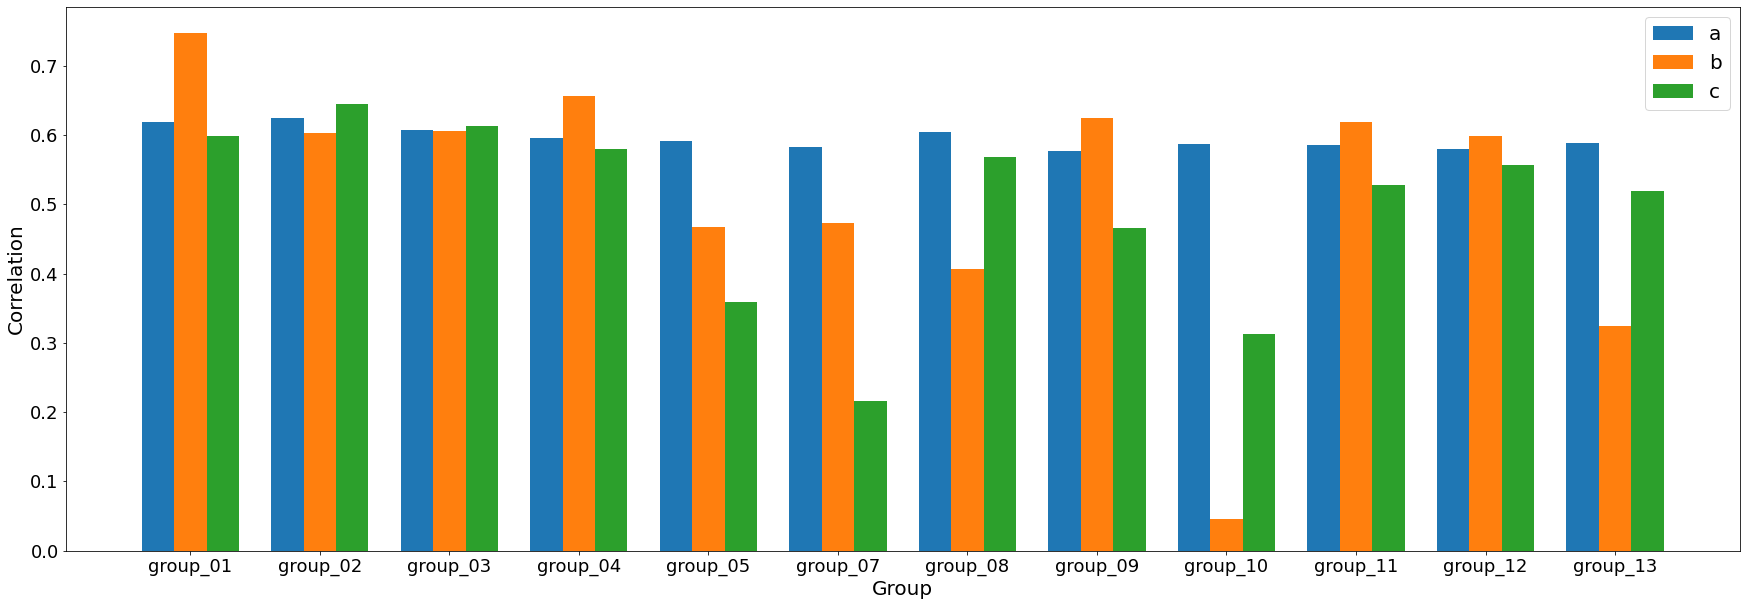

In [113]:
import matplotlib.pyplot as plt

plt.figure(figsize = (30,10))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
x = list(range(len(group_lst[:12])))
total_width, n = 0.75, 3
width = total_width / n
plt.bar(x, a_lst[:12], width=width, label='a')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, b_lst[:12], width=width, label='b', tick_label=group_lst[:12])
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, c_lst[:12], width=width, label='c')
for i in range(len(x)):
    x[i] = x[i] + width
plt.legend(loc=1, prop={'size': 20})
plt.xlabel('Group', fontdict={'size': 20})
plt.ylabel('Correlation', fontdict={'size': 20})
plt.show()


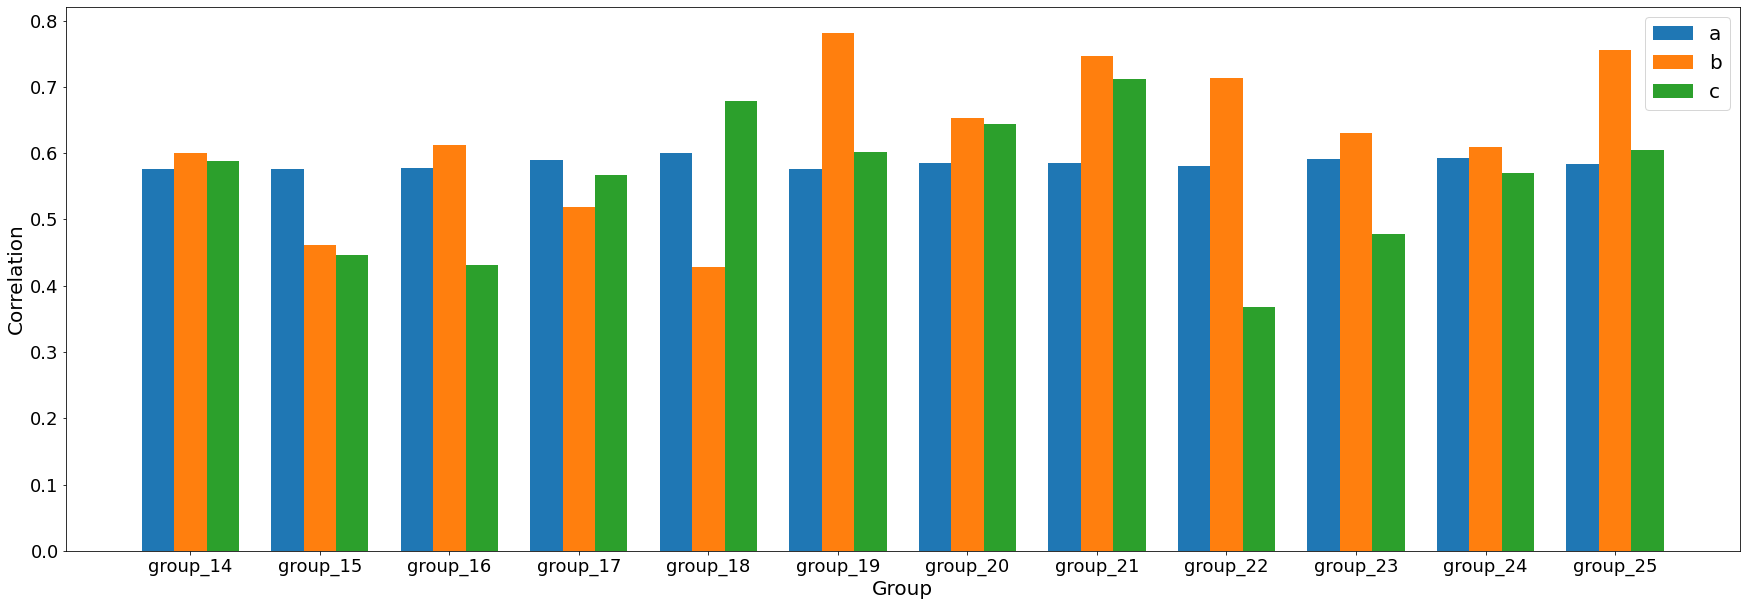

In [114]:
plt.figure(figsize = (30,10))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
x = list(range(len(group_lst[12:])))
total_width, n = 0.75, 3
width = total_width / n
plt.bar(x, a_lst[12:], width=width, label='a')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, b_lst[12:], width=width, label='b', tick_label=group_lst[12:])
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, c_lst[12:], width=width, label='c')
for i in range(len(x)):
    x[i] = x[i] + width
plt.legend(loc=1, prop={'size': 20})
plt.xlabel('Group', fontdict={'size': 20})
plt.ylabel('Correlation', fontdict={'size': 20})
plt.show()

In [116]:
import json

# save the correlation data
filename = "Correlation_result.json"
js_out = {}
js_out['a'] = a_lst
js_out['b'] = b_lst
js_out['c'] = c_lst

with open(filename, "w") as f:
  json.dump(js_out, f)
f.close()